In [1]:
import json
import random
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from scipy.stats import gaussian_kde
import networkx as nx

import network_utils as ne

In [2]:
SAVEFIG = False # saves generated figures to ./figure directory if TRUE
TITLEFONT = {'fontname': 'arial', 'size': 14}
LABELFONT = {'fontname': 'arial', 'size': 14}
LEGENDFONT = {'family': 'arial', 'size': 12}
TICKPARAM = {'family': 'arial', 'size': 12}

In [3]:
with pd.HDFStore('./data/gene_network_data.h5') as store:
    tec = store['TEC']
    rna = store['RNA']
np_tec_abs = np.abs(tec.to_numpy(copy=True))
np_rna_abs = np.abs(rna.to_numpy(copy=True))

In [4]:
# check same gene list between TEC and RNA co-expression 
(tec.columns == rna.columns).all()

np.True_

In [5]:
THRESHOLD = 0.75
rna_al = ne.threshold_weighted_adjacency_list(np_rna_abs, THRESHOLD)
tec_al = ne.threshold_weighted_adjacency_list(np_tec_abs, THRESHOLD)

rna_graph_75 = ne.construct_network(rna_al, "RNA_75", rna.columns)
tec_graph_75 = ne.construct_network(tec_al, "TEC_75", tec.columns)

In [6]:
print(f"TEC Network: {tec_graph_75.number_of_nodes()} nodes with {tec_graph_75.number_of_edges()} edges")
print(f"RNA Network: {rna_graph_75.number_of_nodes()} nodes with {rna_graph_75.number_of_edges()} edges")

TEC Network: 3804 nodes with 26878 edges
RNA Network: 4375 nodes with 52982 edges


#### Figure 2a: 

In [31]:
np_tec = tec.to_numpy(copy=True)
np_rna = rna.to_numpy(copy=True)
np_diff = np_tec - np_rna

# cutoff 0.25 - 26% above 
# cutoff 0.5 - 2.5% above 
# # potential "smoothing" to only highlight large differences 
# cutoff = 0.25
# mask = np.bitwise_and((-1 * cutoff) < np_diff, np_diff < cutoff)
# np_diff[mask] = 0

row_sums = np_diff.sum(axis=1)
perm = np.argsort(row_sums)
np_diff = np_diff[perm, :][:, perm]

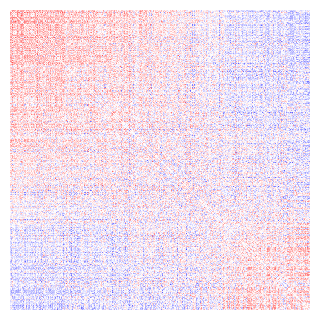

In [8]:
plt.figure(figsize=(3, 3))
hm = sns.heatmap(np_diff, cmap='bwr_r', xticklabels=False, yticklabels=False, cbar=False, center=0)
# Rasterize the main heatmap
hm.collections[0].set_rasterized(True)
plt.subplots_adjust(left=0, right=1, top=1, bottom=0)

if SAVEFIG:
    plt.savefig("./figures/figure2a.pdf", format="pdf", bbox_inches='tight')
plt.show()

#### Figure 2b: 

In [33]:
np_tec = tec.to_numpy(copy=True)
np_rna = rna.to_numpy(copy=True)
np_diff = np_tec - np_rna

subset = list(set(rna_graph_75.nodes).intersection(tec_graph_75.nodes))
np_diff = np_diff[subset, :][:, subset]

# cutoff 0.25 - 32% above 
# cutoff 0.5 - 4% above 
# # potential "smoothing" to only highlight large differences 
# cutoff = 0.25
# mask = np.bitwise_and((-1 * cutoff) < np_diff, np_diff < cutoff)
# np_diff[mask] = 0

row_sums = np_diff.sum(axis=1)
perm = np.argsort(row_sums)
np_diff = np_diff[perm, :][:, perm]

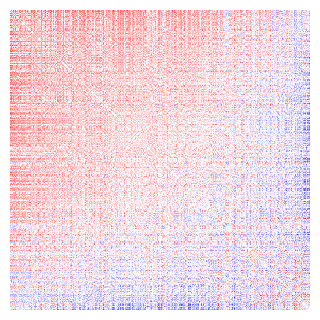

In [10]:
plt.figure(figsize=(3, 3))
hm = sns.heatmap(np_diff, cmap='bwr_r', xticklabels=False, yticklabels=False, cbar=False, center=0)
# Rasterize the main heatmap
hm.collections[0].set_rasterized(True)
plt.subplots_adjust(left=0, right=1, top=1, bottom=0)

if SAVEFIG:
    plt.savefig("./figures/figure2b.pdf", format="pdf", bbox_inches='tight')
plt.show()

#### Figure 2c: Jaccard index between TEC and RNA networks

In [11]:
# get the names of the nodes for both networks
rna_nodes =  {rna_graph_75.nodes[node]['name'] for node in rna_graph_75.nodes()}
tec_nodes =  {tec_graph_75.nodes[node]['name'] for node in tec_graph_75.nodes()}

matching_nodes = rna_nodes.intersection(tec_nodes)
rna_percentage = round((len(matching_nodes) / rna_graph_75.number_of_nodes()) * 100, 2)
tec_percentage = round((len(matching_nodes) / tec_graph_75.number_of_nodes()) * 100, 2)

print(f"Number of matching nodes: {len(matching_nodes)}")
print(f"Percentage of matching nodes for RNA co-expression : {rna_percentage}%")
print(f"Percentage of matching nodes for TEC: {tec_percentage}%")

Number of matching nodes: 2722
Percentage of matching nodes for RNA co-expression : 62.22%
Percentage of matching nodes for TEC: 71.56%


In [12]:
# generate a mapping between node name and node idx, check that it is same idx for both networks
idx2name = dict()
name2idx = dict()
for matched_node in matching_nodes:
    for rna_node in rna_graph_75.nodes():
        if rna_graph_75.nodes[rna_node]['name'] == matched_node:
            if tec_graph_75.nodes[rna_node]['name'] != matched_node: # safety check 
                print(f"{matched_node} has different idx between networks! (RNA: {rna_node})")
            else:
                name2idx[matched_node] = rna_node     
                idx2name[rna_node] = matched_node     

In [13]:
jaccard_sim = ne.jaccard_similarity(rna_graph_75, tec_graph_75, matching_nodes, name2idx)
similarities = list(jaccard_sim.values())

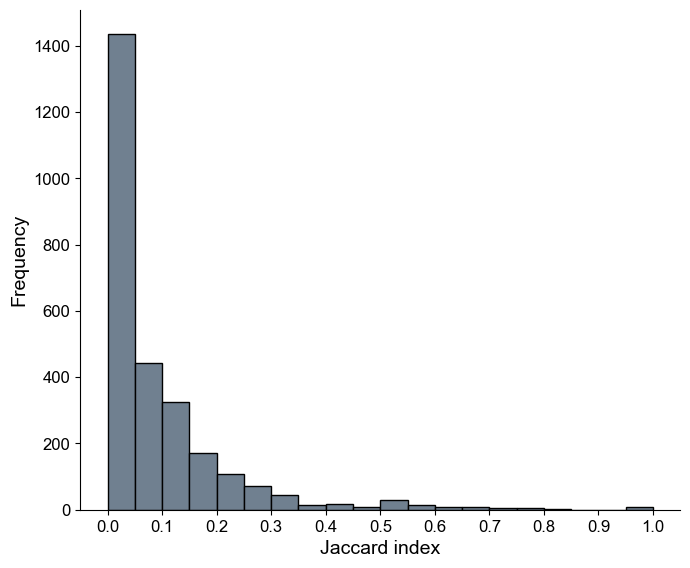

In [14]:
plt.figure(figsize=(6, 5))
plt.hist(similarities, bins=20, edgecolor='black', alpha=1, color='slategray', density=False)

plt.xticks(ticks=[i/10.0 for i in range(11)], **TICKPARAM)
plt.yticks(**TICKPARAM)
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.subplots_adjust(left=0, right=1, top=1, bottom=0)

if SAVEFIG:
    plt.savefig("./figures/figure2c.pdf", format="pdf", bbox_inches='tight', pad_inches=0)
else:
    plt.xlabel("Jaccard index", **LABELFONT)
    plt.ylabel("Frequency", **LABELFONT)
plt.show()

#### Figure 2d: Jaccard index vs. average node degree

In [15]:
avg_deg = []
jacc_idx = []
for node in matching_nodes:
    node_idx = name2idx[node]
    # deg = (rna_graph_75.degree(node_idx, weight='weight') + tec_graph_75.degree(node_idx, weight='weight')) / 2 # weighted version
    deg = (rna_graph_75.degree(node_idx) + tec_graph_75.degree(node_idx)) / 2
    avg_deg.append(deg)
    jacc_idx.append(jaccard_sim[node])

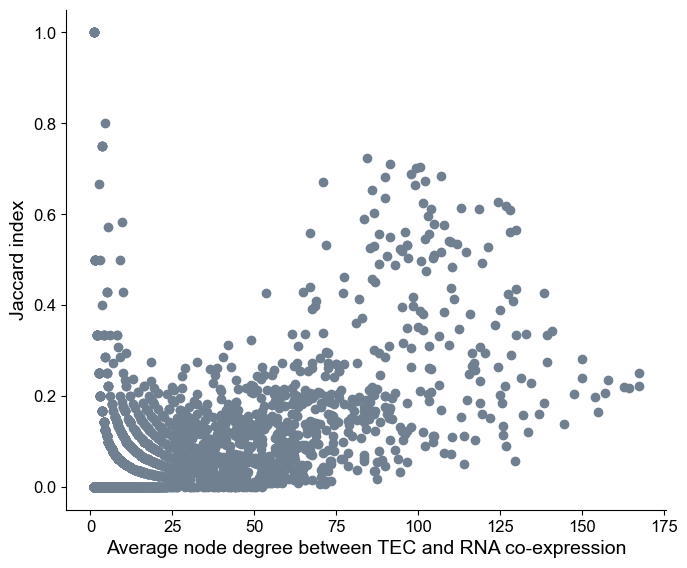

In [16]:
plt.figure(figsize=(6, 5))
plt.scatter(avg_deg, jacc_idx, color='slategray')

plt.xticks(**TICKPARAM)
plt.yticks(**TICKPARAM)
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.subplots_adjust(left=0, right=1, top=1, bottom=0)

if SAVEFIG:
    plt.savefig("./figures/figure2d.pdf", format="pdf", bbox_inches='tight', pad_inches=0)
else:
    plt.xlabel("Average node degree between TEC and RNA co-expression", **LABELFONT)
    plt.ylabel("Jaccard index", **LABELFONT)
plt.show()

#### Figure 2e: Similar subnetwork

In [17]:
sim_subnetwork = []
sum_jac = 0
rna_connectivity = 0
tec_connectivity = 0
for node, jac in dict(sorted(jaccard_sim.items(), key=lambda item: item[1], reverse=True)[:45]).items():
    if node.startswith("RPS") or node.startswith("RPL"): 
        sim_subnetwork.append(name2idx[node])
        sum_jac += jac
        rna_connectivity += rna_graph_75.degree(name2idx[node])
        tec_connectivity += tec_graph_75.degree(name2idx[node])

rna_sim_net = rna_graph_75.subgraph(sim_subnetwork).copy()
tec_sim_net = tec_graph_75.subgraph(sim_subnetwork).copy()

rna_edges = set(rna_sim_net.edges())
tec_edges = set(tec_sim_net.edges())
shared_edges = rna_edges & tec_edges
rna_uniq_edges = rna_edges - tec_edges
tec_uniq_edges = tec_edges - rna_edges

In [18]:
print(f'Number of nodes in subnetwork: {len(sim_subnetwork)}')
print(f'Average jaccard index of nodes in subnetwork: {sum_jac / len(sim_subnetwork)}')
print(f'Average RNA node degree for nodes in subnetwork: {rna_connectivity / len(sim_subnetwork)}')
print(f'Average TEC node degree for nodes in subnetwork: {tec_connectivity / len(sim_subnetwork)}')

Number of nodes in subnetwork: 26
Average jaccard index of nodes in subnetwork: 0.6315141764472
Average RNA node degree for nodes in subnetwork: 98.53846153846153
Average TEC node degree for nodes in subnetwork: 105.53846153846153


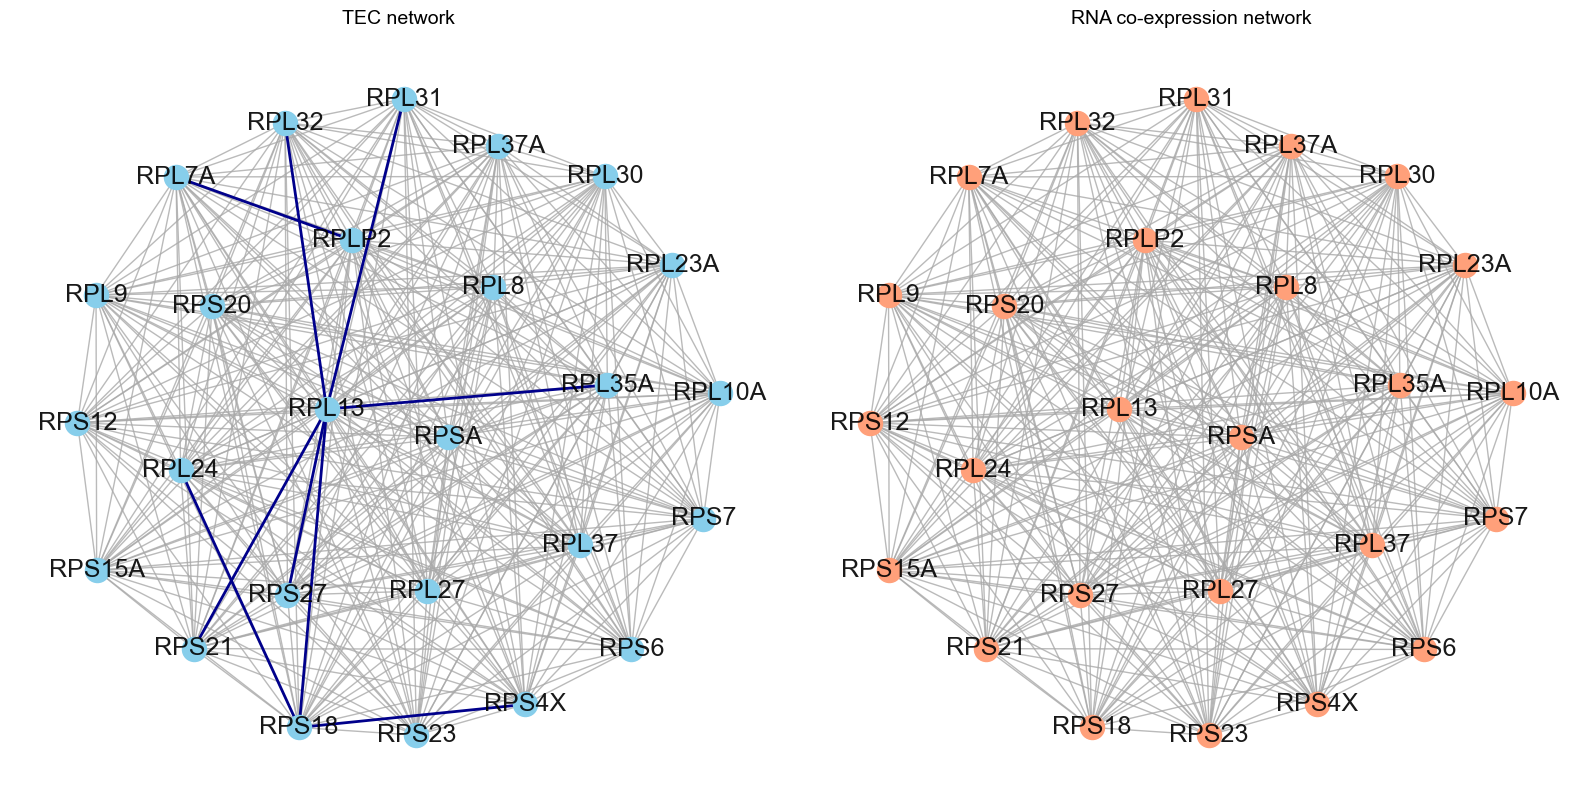

In [19]:
shared_edge_option = {"edge_color": "darkgrey", "alpha": 0.8, "width": 1}

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))  

pos = nx.kamada_kawai_layout(tec_sim_net)

tec_labels = {node: tec_sim_net.nodes[node]['name'] for node in tec_sim_net.nodes()}
nx.draw_networkx_nodes(tec_sim_net, pos, ax=ax1, node_color='skyblue')
nx.draw_networkx_labels(tec_sim_net, pos, tec_labels, ax=ax1, font_size=18, font_color="black", font_family='arial', alpha=0.9)
nx.draw_networkx_edges(tec_sim_net, pos, ax=ax1, edgelist=shared_edges, **shared_edge_option)
nx.draw_networkx_edges(tec_sim_net, pos, ax=ax1, edgelist=tec_uniq_edges, edge_color="darkblue", width=2)

rna_labels = {node: rna_sim_net.nodes[node]['name'] for node in rna_sim_net.nodes()}
nx.draw_networkx_nodes(rna_sim_net, pos, ax=ax2, node_color='lightsalmon')
nx.draw_networkx_labels(rna_sim_net, pos, rna_labels, ax=ax2, font_size=18, font_color="black", font_family='arial', alpha=0.9)
nx.draw_networkx_edges(rna_sim_net, pos, ax=ax2, edgelist=shared_edges, **shared_edge_option)
nx.draw_networkx_edges(rna_sim_net, pos, ax=ax2, edgelist=rna_uniq_edges, edge_color="maroon", width=2)

ax1.axis('off')
ax2.axis('off')
plt.tight_layout()

if SAVEFIG:
    plt.savefig("./figures/figure2e.pdf", format="pdf", bbox_inches='tight')
else:
    ax1.set_title(f'TEC network', **TITLEFONT)
    ax2.set_title(f'RNA co-expression network', **TITLEFONT)
plt.show()

#### Supplementary table 2

In [20]:
diff_table = []
for node, jac in dict(sorted(jaccard_sim.items(), key=lambda item: item[1], reverse=False)).items():
    rna_deg = rna_graph_75.degree(name2idx[node])
    tec_deg = tec_graph_75.degree(name2idx[node])
    rna_clust = nx.clustering(rna_graph_75, nodes=name2idx[node], weight='weight')
    tec_clust = nx.clustering(tec_graph_75, nodes=name2idx[node], weight='weight')
    diff_table.append((node, round(jac, 4), tec_deg, rna_deg, round(tec_clust, 4), round(rna_clust, 4)))
    
diff_table = pd.DataFrame(
    diff_table, 
    columns=['Gene name', 'Jaccard index', 'TEC degree', 'RNA degree', 'TEC clustering', 'RNA clustering']
)

diff_table = diff_table.sort_values(
    by=['TEC clustering', 'RNA clustering'], 
    key = lambda x: (diff_table['TEC clustering'] + diff_table['RNA clustering']) / 2, 
    ascending=False
)
diff_table = diff_table.reset_index(drop=True)
diff_table.head()

,Gene name,Jaccard index,TEC degree,RNA degree,TEC clustering,RNA clustering
0,MT.ATP6,0.7500,4,3,0.9199,0.9572
1,MT.ND4L,0.7500,4,3,0.9059,0.9545
2,MT.CO2,0.7500,4,3,0.9118,0.9455
3,MT.ATP8,0.7500,4,3,0.8920,0.9513
4,RPL13,0.5581,84,50,0.8857,0.7696


#### Figure 2f: Divergent subnetwork

In [21]:
star_node = name2idx['CDC7']

rna_sub = list(rna_graph_75.neighbors(star_node))
rna_sub.append(star_node)
tec_sub = list(tec_graph_75.neighbors(star_node))
tec_sub.append(star_node)

rna_sub = rna_graph_75.subgraph(rna_sub).copy()
tec_sub = tec_graph_75.subgraph(tec_sub).copy()

rna_edges = set(rna_sub.edges())
tec_edges = set(tec_sub.edges())
shared_edges = rna_edges & tec_edges
rna_uniq_edges = rna_edges - tec_edges
tec_uniq_edges = tec_edges - rna_edges

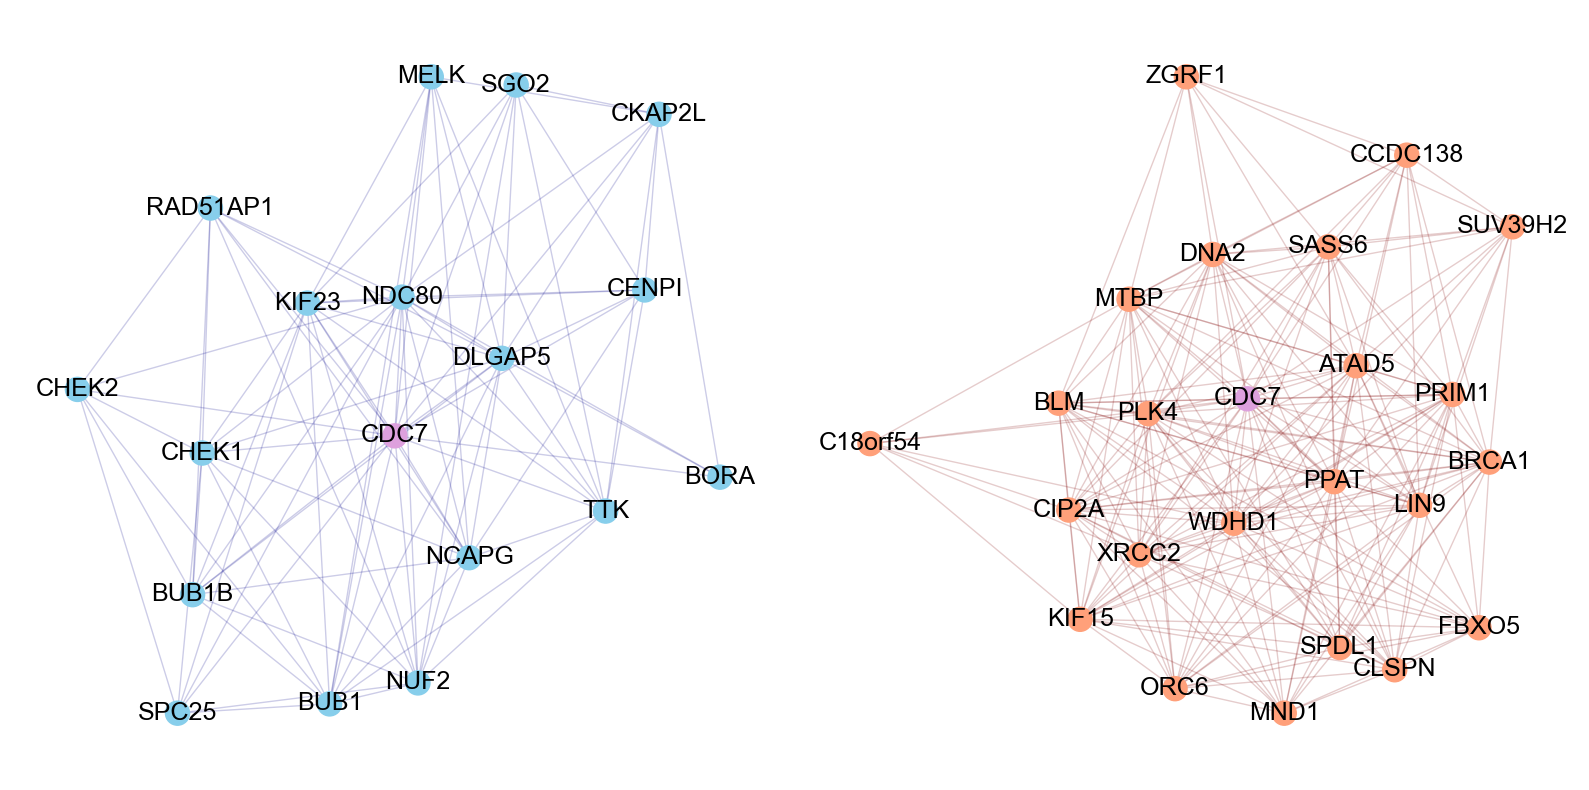

In [22]:
shared_edge_option = {"edge_color": "darkgrey", "alpha": 0.8, "width": 1}

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))  

pos = nx.kamada_kawai_layout(tec_sub)
node_color = ['plum' if node == star_node else 'skyblue' for node in tec_sub.nodes]
tec_labels = {node: tec_sub.nodes[node]['name'] for node in tec_sub.nodes()}
nx.draw_networkx_nodes(tec_sub, pos, ax=ax1, node_color=node_color)
nx.draw_networkx_labels(tec_sub, pos, tec_labels, ax=ax1, font_size=18, font_color="black", font_family='arial', alpha=1)
nx.draw_networkx_edges(tec_sub, pos, ax=ax1, edgelist=shared_edges, **shared_edge_option)
nx.draw_networkx_edges(tec_sub, pos, ax=ax1, edgelist=tec_uniq_edges, edge_color="darkblue", width=1, alpha=0.2)

pos = nx.kamada_kawai_layout(rna_sub)
node_color = ['plum' if node == star_node else 'lightsalmon' for node in rna_sub.nodes]
rna_labels = {node: rna_sub.nodes[node]['name'] for node in rna_sub.nodes()}
nx.draw_networkx_nodes(rna_sub, pos, ax=ax2, node_color=node_color)
nx.draw_networkx_labels(rna_sub, pos, rna_labels, ax=ax2, font_size=18, font_color="black", font_family='arial', alpha=1)
nx.draw_networkx_edges(rna_sub, pos, ax=ax2, edgelist=shared_edges, **shared_edge_option)
nx.draw_networkx_edges(rna_sub, pos, ax=ax2, edgelist=rna_uniq_edges, edge_color="maroon", width=1, alpha=0.2)

ax1.axis('off')
ax2.axis('off')
plt.tight_layout()

if SAVEFIG:
    plt.savefig("./figures/figure2f.pdf", format="pdf", bbox_inches='tight')
plt.show()

In [23]:
star_name = idx2name[star_node]
tec_neighbors = [n for n in tec_labels.values() if n != star_name]
rna_neighbors = [n for n in rna_labels.values() if n != star_name]

tec_difference = sorted(
    [(n, tec.loc[n, star_name] - rna.loc[n, star_name]) for n in tec_neighbors],
    key=lambda x: x[1], reverse=True
)
rna_difference = sorted(
    [(n, rna.loc[n, star_name] - tec.loc[n, star_name]) for n in rna_neighbors],
    key=lambda x: x[1]
)

tec_diff = []
tec_neighbors = []
for t in tec_difference:
    tec_neighbors.append(t[0])
    tec_diff.append(t[1])

rna_diff = []
rna_neighbors = []
for t in rna_difference:
    rna_neighbors.append(t[0])
    rna_diff.append(t[1])

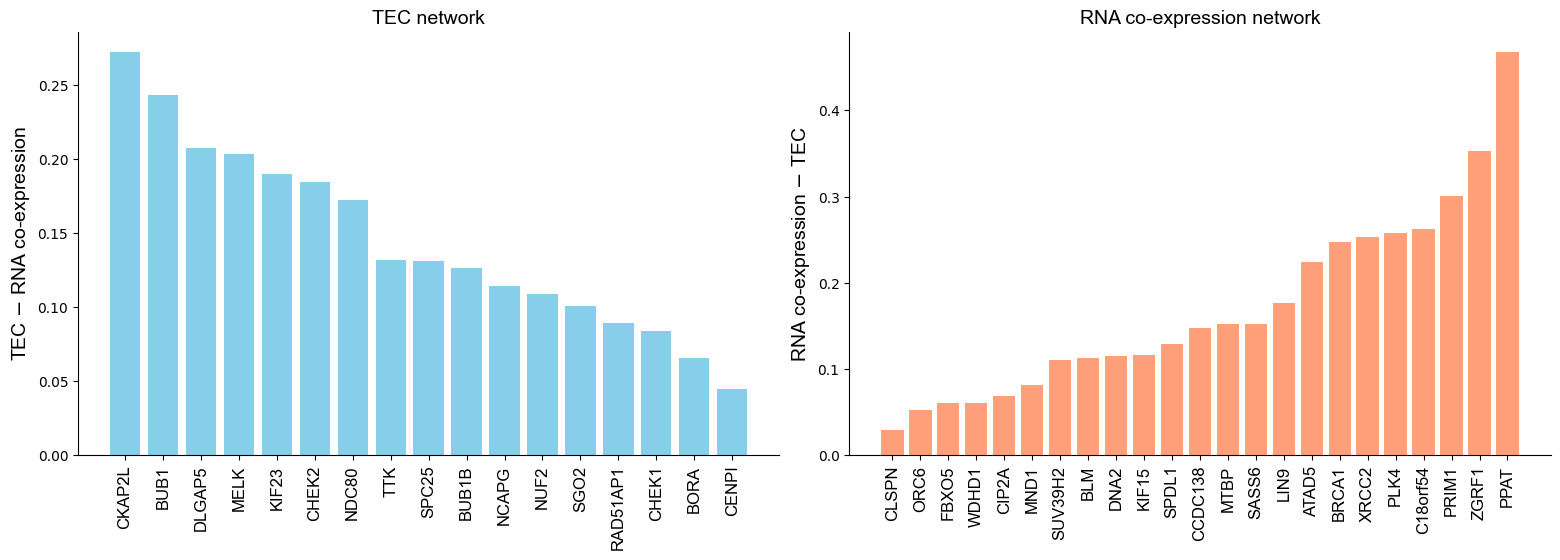

In [42]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(19, 5.5), gridspec_kw={'wspace': 0.1})

ax1.bar(range(len(tec_diff)), tec_diff, color='skyblue')

ax1.set_xticks(range(len(tec_neighbors)))
ax1.set_xticklabels(tec_neighbors, rotation=90, **TICKPARAM)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)

ax2.bar(range(len(rna_diff)), rna_diff, color='lightsalmon')
ax2.set_xticks(range(len(rna_neighbors)))
ax2.set_xticklabels(rna_neighbors, rotation=90, **TICKPARAM)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)

if SAVEFIG:
    plt.savefig("./supplemental/supp_fig/fig2.pdf", format="pdf", bbox_inches='tight', pad_inches=0)
else:
    ax1.set_ylabel('TEC $-$ RNA co-expression', **LABELFONT)
    ax2.set_ylabel('RNA co-expression $-$ TEC', **LABELFONT)
    ax1.set_title('TEC network', **TITLEFONT)
    ax2.set_title('RNA co-expression network', **TITLEFONT)
plt.show()

#### Figure 2g: Matching degree centrality comparison

In [25]:
rna_degrees = []
tec_degrees = []
rna_deg_imbalance = [] # nodes that have higher connectivity in RNA co-expression network
tec_deg_imbalance = [] # nodes that have higher connectivity in TEC network

for node_name in matching_nodes:
    curr_idx = name2idx[node_name]
    rna_deg = rna_graph_75.degree(curr_idx, weight='weight')
    tec_deg = tec_graph_75.degree(curr_idx, weight='weight')
    
    rna_degrees.append(rna_deg)
    tec_degrees.append(tec_deg)
    rna_deg_imbalance.append( (rna_deg - tec_deg, node_name, (rna_deg, tec_deg)))
    tec_deg_imbalance.append( (tec_deg - rna_deg, node_name, (tec_deg, rna_deg)))

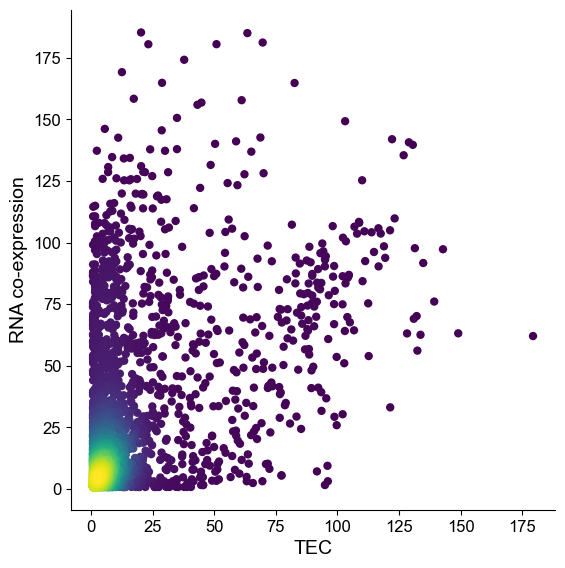

In [26]:
rna_degrees = np.array(rna_degrees, dtype=np.float64)
tec_degrees = np.array(tec_degrees, dtype=np.float64)
stacked_deg = np.vstack([tec_degrees, rna_degrees]) # stack together
est_density = gaussian_kde(stacked_deg)(stacked_deg) # compute density using Gaussian KDE

# Sort points by density for layering
idx = est_density.argsort()
rna_degrees, tec_degrees, est_density = rna_degrees[idx], tec_degrees[idx], est_density[idx]

plt.figure(figsize=(5, 5))
plt.scatter(tec_degrees, rna_degrees, c=est_density, cmap='viridis', s=25)
# cbar = plt.colorbar(label='Estimated Density')
# cbar.ax.set_yticklabels([])   # Hide tick labels
# cbar.set_label('Density (sparse → dense)', rotation=270, labelpad=15)

plt.xticks(**TICKPARAM)
plt.yticks(**TICKPARAM)
ax = plt.gca()
ax.set_aspect('equal')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.subplots_adjust(left=0, right=1, top=1, bottom=0)

if SAVEFIG:
    plt.savefig("./figures/figure2g.pdf", format="pdf", bbox_inches='tight', pad_inches=0)
else:
    plt.xlabel('TEC', **LABELFONT)
    plt.ylabel('RNA co-expression', **LABELFONT)
plt.show()

#### Figure 2h: Betweenness centrality

In [27]:
tec_betw_dict = nx.betweenness_centrality(tec_graph_75, weight='weight')
rna_betw_dict = nx.betweenness_centrality(rna_graph_75, weight='weight')
tec_betw = []
rna_betw = []
tec_betw_imbalance = [] # nodes that have higher betweeness centrality in TEC network
rna_betw_imbalance = [] # nodes that have higher betweeness centrality in RNA co-expression network

for node_name in matching_nodes:
    curr_idx = name2idx[node_name]
    curr_tec_betw = tec_betw_dict[curr_idx]
    curr_rna_betw = rna_betw_dict[curr_idx]
    
    tec_betw.append(curr_tec_betw)
    rna_betw.append(curr_rna_betw)
    tec_betw_imbalance.append( (curr_tec_betw - curr_rna_betw, node_name, (curr_tec_betw, curr_rna_betw)))
    rna_betw_imbalance.append( (curr_rna_betw - curr_tec_betw, node_name, (curr_rna_betw, curr_tec_betw)))

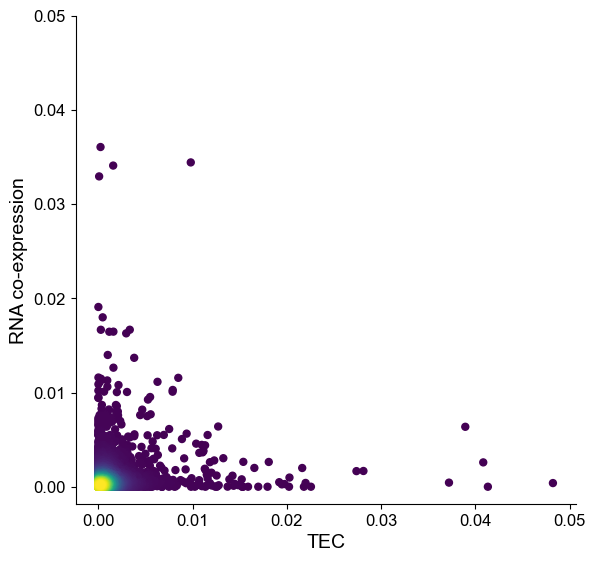

In [28]:
rna_betw = np.array(rna_betw, dtype=np.float64)
tec_betw = np.array(tec_betw, dtype=np.float64)
stacked_deg = np.vstack([tec_betw, rna_betw]) # stack together [(tec_deg, rna_deg)]
est_density = gaussian_kde(stacked_deg)(stacked_deg) # compute density using Gaussian KDE

# Sort points by density for layering
idx = est_density.argsort()
rna_betw, tec_betw, est_density = rna_betw[idx], tec_betw[idx], est_density[idx]

plt.figure(figsize=(5, 5))
plt.scatter(tec_betw, rna_betw, c=est_density, cmap='viridis', s=25)

plt.xticks(ticks=[i * 0.01 for i in range(6)], **TICKPARAM)
plt.yticks(ticks=[i * 0.01 for i in range(6)], **TICKPARAM)
ax = plt.gca()
ax.set_aspect('equal')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.subplots_adjust(left=0, right=1, top=1, bottom=0)

if SAVEFIG:
    plt.savefig("./figures/figure2h.pdf", format="pdf", bbox_inches='tight', pad_inches=0)
else:
    plt.xlabel('TEC', **LABELFONT)
    plt.ylabel('RNA co-expression', **LABELFONT)   
plt.show()

#### Figure 2i: Closeness centrality

In [29]:
rna_closeness = []
tec_closeness = []
rna_closeness_imbalance = []
tec_closeness_imbalance = []

for node_name in matching_nodes:
    curr_idx = name2idx[node_name]
    rna_close = nx.closeness_centrality(rna_graph_75, curr_idx, distance="weight")
    tec_close = nx.closeness_centrality(tec_graph_75, curr_idx, distance="weight")

    rna_closeness.append(rna_close)
    tec_closeness.append(tec_close)
    rna_closeness_imbalance.append( (rna_close - tec_close, node_name, (rna_close, tec_close)) )
    tec_closeness_imbalance.append( (tec_close - rna_close, node_name, (rna_close, tec_close)) )

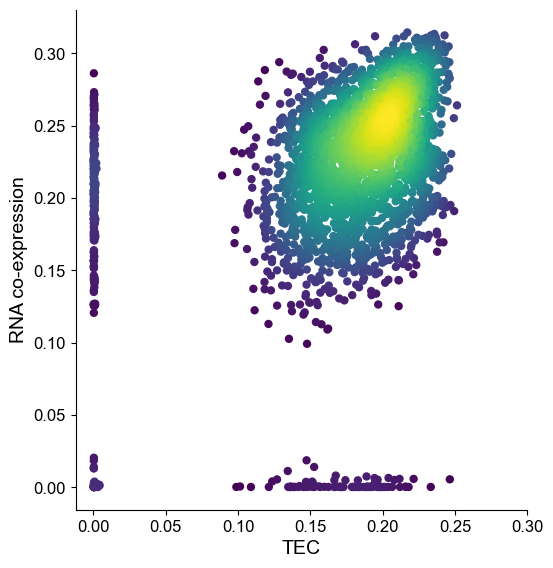

In [30]:
rna_closeness = np.array(rna_closeness, dtype=np.float64)
tec_closeness = np.array(tec_closeness, dtype=np.float64)
stacked_deg = np.vstack([tec_closeness, rna_closeness]) # stack together
est_density = gaussian_kde(stacked_deg)(stacked_deg) # compute density using Gaussian KDE

# Sort points by density for layering
idx = est_density.argsort()
rna_closeness, tec_closeness, est_density = rna_closeness[idx], tec_closeness[idx], est_density[idx]

plt.figure(figsize=(5, 5))
plt.scatter(tec_closeness, rna_closeness, c=est_density, cmap='viridis', s=25)

plt.xticks(ticks=[i * 0.05 for i in range(7)], **TICKPARAM)
plt.yticks(ticks=[i * 0.05 for i in range(7)], **TICKPARAM)
ax = plt.gca()
ax.set_aspect('equal')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.subplots_adjust(left=0, right=1, top=1, bottom=0)

if SAVEFIG:
    plt.savefig("./figures/figure2i.pdf", format="pdf", bbox_inches='tight', pad_inches=0)
else:                   
    plt.xlabel('TEC', **LABELFONT)
    plt.ylabel('RNA co-expression', **LABELFONT)
plt.show()